# Análise de dados dos filmes exibidos no Brasil 

In [84]:
# Bibliotecas utilizadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
import seaborn as sns
import os
import geopandas as gpd
from IPython.display import HTML

## Preparando o dataframe que será utilizado nas análises

In [85]:
# Pasta dos arquivos
pasta = '/Users/bentofh/Documents/GitHub/ancine/Bilheteria/'

In [86]:
# Lista para armazenar os dataframes
dataframes = []

# Range de análise 
ano_min_analise = 2014
ano_max_analise = 2024

# Itera sobre os arquivos na pasta
for ano in range(ano_min_analise, ano_max_analise):
    arquivo = os.path.join(pasta, f'BilheteriaObrasDia_{ano}.parquet')
    df = pd.read_parquet(arquivo)
    dataframes.append(df)

# Combina todos os dataframes em um único
df = pd.concat(dataframes, ignore_index=True)

In [87]:
# Gerando uma amostra aleatória ou utilizando todos os dados 
df = df #.sample(n=1000000)

# Selecionar apenas as colunas desejadas
colunas_selecionadas = ['DT_EXIBICAO', 'TITULO_ORIGINAL', 'TITULO_BRASILEIRO', 'PAIS', 'UF_COMPLEXO', 'MUNICIPIO_COMPLEXO', 'RAZAO_SOCIAL_DISTRIBUIDORA', 'PUBLICO']
df = df[colunas_selecionadas]

# Convertendo 'DT_EXIBICAO' para o formato de data
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'], format='%d/%m/%Y')

# Caso necessite do arquivo
# df.to_parquet(os.path.join(pasta,r'BrilheteriaAmostra.parquet'))
# df.to_csv(os.path.join(pasta,r'BrilheteriaAmostra.csv'), index=False)

# Tamanho do df
df.shape

(14724474, 8)

## Amostra dos dados disponíveis no arquivo original disponibilizado pela ANCINE

In [88]:
# Primeiras linhas do dataframe 
df.head(5)

,DT_EXIBICAO,TITULO_ORIGINAL,TITULO_BRASILEIRO,PAIS,UF_COMPLEXO,MUNICIPIO_COMPLEXO,RAZAO_SOCIAL_DISTRIBUIDORA,PUBLICO
0,2014-12-04,ISLAND OF LEMURS: MADAGASCAR 3D,ILHA DOS LÊMURES: MADAGASCAR - 3D,"Canadá, Estados Unidos, Madagascar",RS,PORTO ALEGRE,CINEARTE POMPEIA LTDA,2
1,2014-10-24,ISLAND OF LEMURS: MADAGASCAR 3D,ILHA DOS LÊMURES: MADAGASCAR - 3D,"Canadá, Estados Unidos, Madagascar",SP,COTIA,CINEARTE POMPEIA LTDA,0
2,2014-10-30,ISLAND OF LEMURS: MADAGASCAR 3D,ILHA DOS LÊMURES: MADAGASCAR - 3D,"Canadá, Estados Unidos, Madagascar",SP,COTIA,CINEARTE POMPEIA LTDA,1
3,2014-10-23,ISLAND OF LEMURS: MADAGASCAR 3D,ILHA DOS LÊMURES: MADAGASCAR - 3D,"Canadá, Estados Unidos, Madagascar",RS,PORTO ALEGRE,CINEARTE POMPEIA LTDA,1
4,2014-10-29,ISLAND OF LEMURS: MADAGASCAR 3D,ILHA DOS LÊMURES: MADAGASCAR - 3D,"Canadá, Estados Unidos, Madagascar",SP,COTIA,CINEARTE POMPEIA LTDA,0


## Definição dar cores que iremos utilizar nas análises

In [89]:
# Configurando as cores personalizadas

paleta = {
    'cor1' : '#1F7387',
    'cor2' : '#EDA946'
}

# Criando gradiente com uma cor
gradiente1 = sns.light_palette(paleta['cor1'], as_cmap=True)

# Criando gradiente com duas cores
gradiente2 = LinearSegmentedColormap.from_list('custom_cmap', [paleta['cor2'], paleta['cor1']])

## Quantos filmes existem no dataset e qual o range de data que estamos analisando?

In [90]:
# Contar o número de títulos de filmes únicos
num_filmes_unicos = df['TITULO_ORIGINAL'].nunique()

# Encontrar as datas mínima e máxima
data_minima = df['DT_EXIBICAO'].min()
data_maxima = df['DT_EXIBICAO'].max()

# Exibir o resultado
texto = (f"O dataset nos indica que {num_filmes_unicos} filmes foram exibidos no Brasil no período de {data_minima.strftime('%d/%m/%Y')} e {data_maxima.strftime('%d/%m/%Y')}")
display(HTML(f"<div style='font-size: 20px;'>{texto}</div>"))

## Anualmente, quantos filmes são exibidos e quantas pessoas vão ao cinema?

In [91]:
# Trabalhando com datetime e especificando o formato correto
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'], format='%d/%m/%Y')

# Extrair o ano da data de exibição
df['Ano'] = df['DT_EXIBICAO'].dt.year

# Agrupar por ano e calcular as métricas
agrupamento = df.groupby('Ano').agg(
    Filmes_Distintos=('TITULO_ORIGINAL', 'nunique'),
    Soma_Publico=('PUBLICO', 'sum')
).reset_index()

# Formatar os números com separador de milhar
agrupamento['Soma_Publico'] = agrupamento['Soma_Publico'].apply(lambda x: f'{x:,.0f}'.replace(',', '.'))

# Reordenar as colunas para melhor apresentação
agrupamento = agrupamento[['Ano', 'Filmes_Distintos', 'Soma_Publico']]

# Exibir a tabela
agrupamento


,Ano,Filmes_Distintos,Soma_Publico
0,2014,840,156.490.000
1,2015,928,169.331.690
2,2016,854,184.881.830
3,2017,797,181.832.840
4,2018,789,163.307.143
5,2019,770,179.281.336
6,2020,564,39.354.394
7,2021,466,53.024.144
8,2022,558,97.407.228
9,2023,308,59.666.534


## Linha temporal da somatória de público
Os dados são disponibilizados a partir de 2014 e sua atualização não ocorre de forma imediata. É possível ver que mesmo o arquivo sendo executado em Janeiro de 2024, ainda não temos os dados completos do ano de 2023. Veja que interessante a enorme queda de público nos cinema brasileiros durante a pandemia de Covid-19.

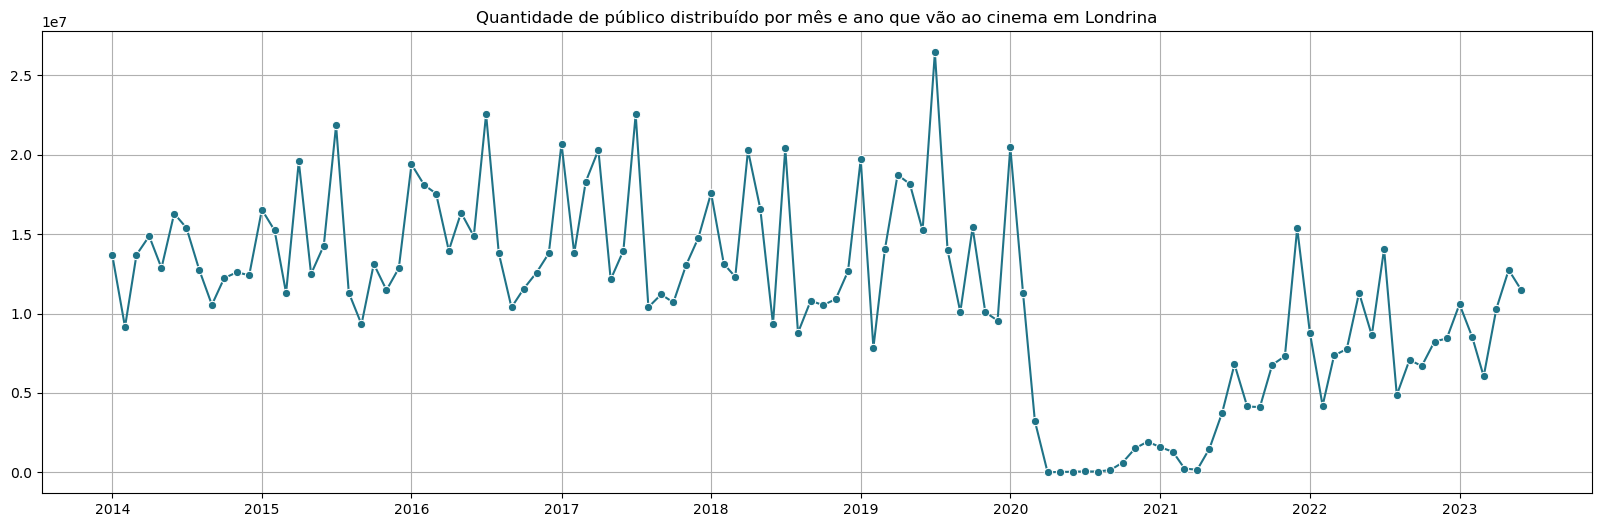

In [92]:
# Agrupar por ano e mês e somar o público
df_agrupado = df.groupby(df['DT_EXIBICAO'].dt.to_period("M"))['PUBLICO'].sum()
df_agrupado = df_agrupado.reset_index()
df_agrupado['DT_EXIBICAO'] = df_agrupado['DT_EXIBICAO'].dt.to_timestamp()

# Encontrar os valores mínimo, máximo e média
minimo = df_agrupado['PUBLICO'].min()
maximo = df_agrupado['PUBLICO'].max()
media = df_agrupado['PUBLICO'].mean()

# Criar o gráfico
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_agrupado, x='DT_EXIBICAO', y='PUBLICO', marker='o', color=paleta['cor1'])

# Configurações adicionais do gráfico
plt.title('Quantidade de público distribuído por mês e ano que vão ao cinema em Londrina')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(True)

# Exibindo o gráfico
plt.show()


## Filmes com maior público no Brasil

Acredito não ser nenhuma surpresa para quem acompanha o mundo do cinema que o filme com maior público no Brasil seja um dos filmes dos Vingadores, ainda que o Ultimato ocupe a segunda posição quando falamos de exibição mundial, ficando atrás apenas do filme Avatar. 

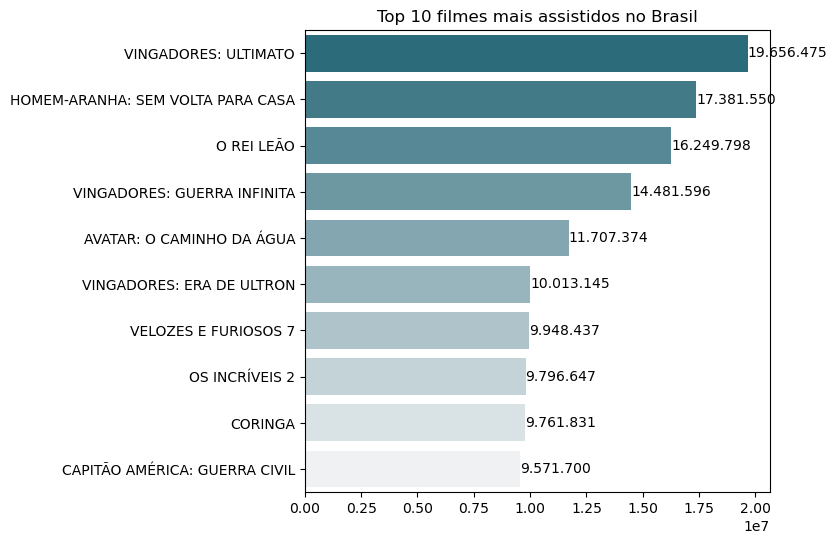

In [93]:
# Agrupar por título brasileiro e somar o público
top_films = df.groupby('TITULO_BRASILEIRO')['PUBLICO'].sum().sort_values(ascending=False).head(10)

# Gerando paletas de cores de acordo com uma cor base
cor_base = paleta['cor1']

# Gerando 10 tons diferentes da cor fornecida
tons = sns.light_palette(cor_base, n_colors=10, reverse=True)

# Convertendo as cores para formato hexadecimal
tons_degrade = [mcolors.to_hex(c) for c in tons]

# Definindo a paleta de cores
colors = tons_degrade

# Criando o gráfico de barras horizontais
plt.figure(figsize=(6, 6))
barplot = sns.barplot(y=top_films.index, x=top_films.values, palette=tons_degrade)

# Configurações adicionais do gráfico
plt.title('Top 10 filmes mais assistidos no Brasil')
plt.xlabel('')
plt.ylabel('')
plt.grid(False, axis='x')

# Adicionando a soma da audiência em frente às barras
for p in barplot.patches:
    width = p.get_width()
    plt.text(width + 3,  # posição x
             p.get_y() + p.get_height() / 2,  # posição y
             f'{width:,.0f}'.replace(',', '.'),  # valor
             ha='left', 
             va='center')

# Exibindo o gráfico
plt.show()

## Quais são os estados com maiores bilheterias? 

Nesse ponto os valores do sudeste são tão discrepantes, que quase não é possível distinguir as cores dos demais estados do país. Por isso mais abaixo realizo um outro tipo de análise envolvendo UF para que possamos entender melhor nossos dados.

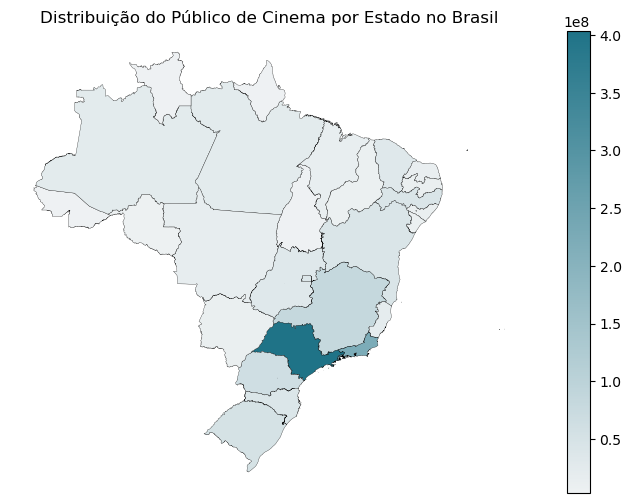

In [94]:
# Agrupar os dados por estado e somar o público
df_publico_por_estado = df.groupby('UF_COMPLEXO')['PUBLICO'].sum().reset_index()

# Carregar o shapefile do Brasil (você precisará de um shapefile do Brasil)
shapefile_path = '/Users/bentofh/Documents/GitHub/ancine/BR_UF_2022/BR_UF_2022.shp'
brasil_map = gpd.read_file(shapefile_path)

# Juntar os dados de público com o shapefile
mapa_final = brasil_map.set_index('SIGLA_UF').join(df_publico_por_estado.set_index('UF_COMPLEXO'))

# Criar o mapa de calor
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
mapa_final.plot(column='PUBLICO', ax=ax, legend=True, cmap=gradiente1, 
                edgecolor='black', linewidth=0.2) 

# Adicionando títulos e labels
plt.title('Distribuição do Público de Cinema por Estado no Brasil')
ax.set_axis_off()

# Mostrar o gráfico
plt.show()

## Bilheteria nacional vs. estrangeira

Acompanhe a linha temporal de público nos cinema brasileiros divindo os filmes em nacional X estrangeiros. 

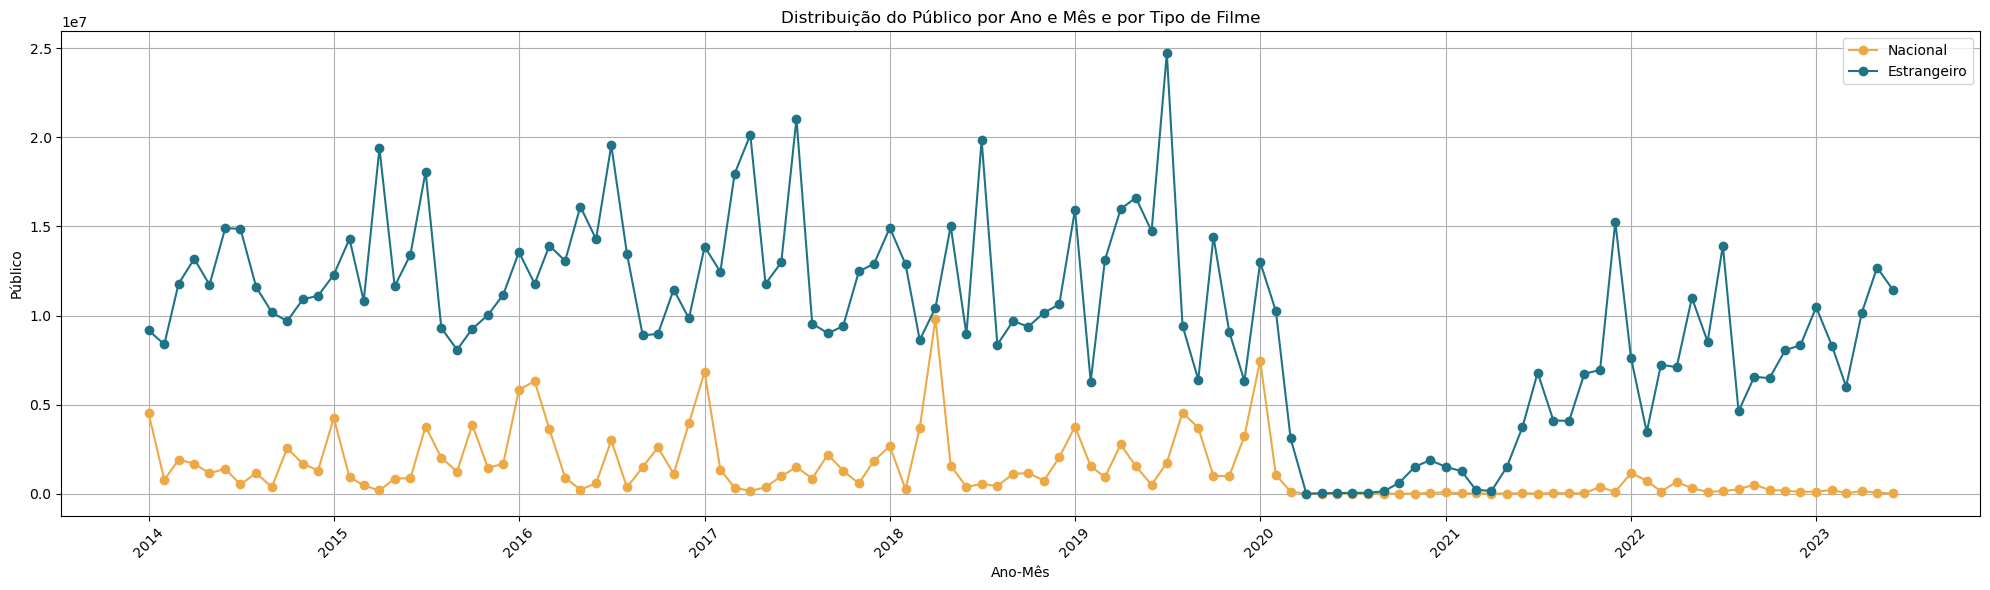

In [95]:
# Converter DT_EXIBICAO para datetime e extrair o ano e mês
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['ANO_MES'] = df['DT_EXIBICAO'].dt.to_period('M')

# Classificar filmes como Nacional ou Estrangeiro
df['TIPO_FILME'] = df['PAIS'].str.upper().apply(lambda x: 'Nacional' if x is not None and 'BRASIL' in x else 'Estrangeiro')

# Agrupar por ano e mês, somando o público
publico_temporal = df.groupby(['ANO_MES', 'TIPO_FILME']).agg({'PUBLICO':'sum'}).reset_index()

# Cores para os tipos de filmes
cores = {'Nacional': paleta['cor2'], 'Estrangeiro': paleta['cor1']}

# Plotar o gráfico
plt.figure(figsize=(20, 6))
for tipo, cor in cores.items():
    subset = publico_temporal[publico_temporal['TIPO_FILME'] == tipo]
    plt.plot(subset['ANO_MES'].dt.to_timestamp(), subset['PUBLICO'], label=tipo, color=cor, marker='o')

plt.title('Distribuição do Público por Ano e Mês e por Tipo de Filme')
plt.xlabel('Ano-Mês')
plt.ylabel('Público')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Percentual de filmes nacionais vs estrangeiros

Ainda no tema filmes nacionais X filmes estrangeiros, aqui está o percentual de cada tipo de filme acumulado por ano.

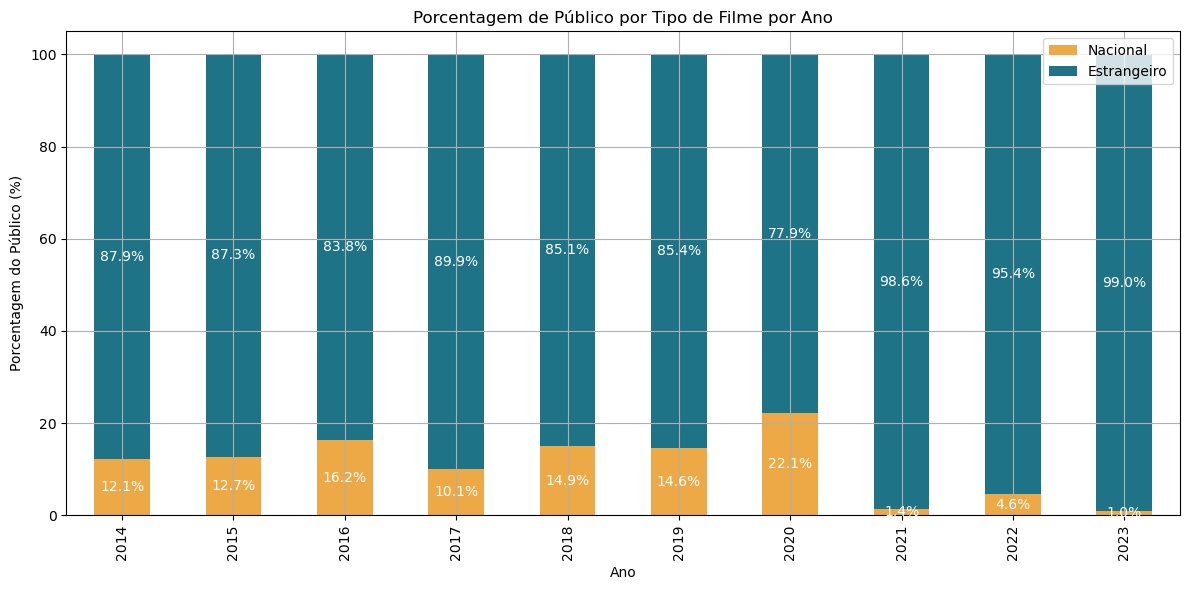

In [96]:
# Converter DT_EXIBICAO para datetime e extrair o ano
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['ANO'] = df['DT_EXIBICAO'].dt.year

# Classificar filmes como Nacional ou Estrangeiro
df['TIPO_FILME'] = df['PAIS'].str.upper().apply(lambda x: 'Nacional' if x is not None and 'BRASIL' in x else 'Estrangeiro')

# Agrupar por ano e tipo de filme, somando o público
publico_por_ano = df.groupby(['ANO', 'TIPO_FILME'])['PUBLICO'].sum().reset_index()

# Pivotear os dados para obter a soma do público por tipo de filme em cada ano
pivot_publico = publico_por_ano.pivot(index='ANO', columns='TIPO_FILME', values='PUBLICO').fillna(0)

# Calcular o total do público por ano
pivot_publico['Total'] = pivot_publico.sum(axis=1)

# Calcular a porcentagem para cada tipo de filme por ano
pivot_publico['Nacional_%'] = (pivot_publico['Nacional'] / pivot_publico['Total']) * 100
pivot_publico['Estrangeiro_%'] = (pivot_publico['Estrangeiro'] / pivot_publico['Total']) * 100

# Cores para os tipos de filmes nas barras
cores_barras = {'Nacional_%': paleta['cor2'], 'Estrangeiro_%': paleta['cor1']}

# Cor das anotações
cor_anotacao = 'white'

# Plotar o gráfico de barras empilhadas
ax = pivot_publico[['Nacional_%', 'Estrangeiro_%']].plot(kind='bar', stacked=True, figsize=(12, 6), color=[cores_barras['Nacional_%'], cores_barras['Estrangeiro_%']])

plt.title('Porcentagem de Público por Tipo de Filme por Ano')
plt.xlabel('Ano')
plt.ylabel('Porcentagem do Público (%)')

# Adicionando anotações de porcentagem
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0: # Verifica se a barra tem altura para evitar etiquetas em barras vazias
        ax.text(x+width/2, 
                y+height/2, 
                '{:.1f}%'.format(height), 
                ha='center', 
                va='center', 
                color=cor_anotacao)

plt.legend(['Nacional', 'Estrangeiro'])
plt.grid(True)
plt.tight_layout()
plt.show()


### No notebook 3 realizado uma consulta no site IMDB para buscar as informações sobre gênero dos filmes que estamos tratando aqui.

In [97]:
# Caminhos dos arquivos Parquet
pasta_imdb = '/Users/bentofh/Documents/GitHub/ancine/IMDB'
caminho_arquivo_imdb = os.path.join(pasta_imdb, 'imdb.parquet')
df_imdb = pd.read_parquet(caminho_arquivo_imdb)

# Converter os títulos para maiúsculas e obter títulos únicos com frequência
df['TITULO_ORIGINAL'] = df['TITULO_ORIGINAL'].str.upper()
titulos_unicos = df['TITULO_ORIGINAL'].value_counts().reset_index()
titulos_unicos.columns = ['TITULO_ORIGINAL', 'FREQUENCIA']

# Converter títulos no df_imdb para maiúsculas
df_imdb['originalTitle'] = df_imdb['originalTitle'].str.upper()

# Realizar o join com títulos únicos
df_joined = titulos_unicos.merge(df_imdb[['originalTitle', 'genres']], left_on='TITULO_ORIGINAL', right_on='originalTitle', how='left')

# Renomear a coluna 'genres' para 'GENERO_FILME' e remover a coluna 'originalTitle' redundante
df_joined.rename(columns={'genres': 'GENERO_FILME'}, inplace=True)
df_joined.drop(columns=['originalTitle'], inplace=True)

# Contar os top 10 gêneros de filmes
top_generos = df_joined['GENERO_FILME'].value_counts().head(10)
print(top_generos)

GENERO_FILME
Comedy         6112
Drama          5501
Documentary    2317
Action         1532
Talk-Show      1503
Short          1488
Horror          960
Animation       920
Crime           847
Adventure       691
Name: count, dtype: int64


## O Brasil ama uma comédia 

Nesse ponto é importante mencionar que não foi possível realizar uma contagem exata dos filmes exibidos no brasil por gênero, já que as bases são de fontes distintas e um mesmo filme acaba sendo registrado de formas diferentes. Ainda tentei realizar uma análise de fuzzy, mas meu notebook pessoal não foi capaz de executar pela quantidade de dados. Num próximo projeto dedicado a isso poderemos ver aplicações nesse sentido.

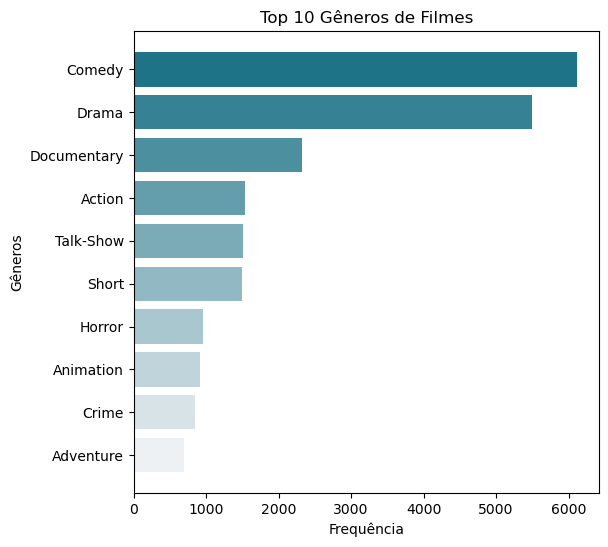

In [98]:
# Gerando paletas de cores de acordo com uma cor base
cor_base = paleta['cor1']
tons = sns.light_palette(cor_base, n_colors=10, reverse=True)
tons_degrade = [mcolors.to_hex(c) for c in tons]
cores = tons_degrade

# Plotar um gráfico de barras horizontal
plt.figure(figsize=(6, 6))
barras = plt.barh(top_generos.index, top_generos.values, color=cores)
plt.title('Top 10 Gêneros de Filmes')
plt.xlabel('Frequência')
plt.ylabel('Gêneros')
plt.gca().invert_yaxis()  # Inverter o eixo y para o maior valor aparecer no topo
plt.show()

## Qual o melhor e o pior dia de bilheteria no Brasil?

Veja logo abaixo a resposta e analise o mapa de calor que acumula os dados em uma matriz dia x mês e as cores são distribuídas de acordo com o público. 

In [99]:
# Converter 'DT_EXIBICAO' para datetime e extrair dia e mês
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['Dia'] = df['DT_EXIBICAO'].dt.day
df['Mes'] = df['DT_EXIBICAO'].dt.month

# Agrupar por dia e mês, somando o público
agrupamento = df.groupby(['Dia', 'Mes'])['PUBLICO'].sum().reset_index()

# Encontrar o valor máximo e mínimo e suas posições
max_value = agrupamento['PUBLICO'].max()
min_value = agrupamento['PUBLICO'].min()

# Encontrar os dias e meses correspondentes
max_dia_mes = agrupamento[agrupamento['PUBLICO'] == max_value][['Dia', 'Mes']]
min_dia_mes = agrupamento[agrupamento['PUBLICO'] == min_value][['Dia', 'Mes']]

max_dia = max_dia_mes['Dia'].iloc[0]
max_mes = max_dia_mes['Mes'].iloc[0]
min_dia = min_dia_mes['Dia'].iloc[0]
min_mes = min_dia_mes['Mes'].iloc[0]


# Adicionar legenda com a data de maior e menor frequência
melhor_dia = f"A data com maior frequência de público nos cinemas é {max_dia}/{max_mes}"
pior_dia = f"e a de menor frequência é {min_dia}/{min_mes}"

# Dias com maior e menor frequência de público
texto = (f"{melhor_dia}, {pior_dia}")
display(HTML(f"<div style='font-size: 20px;'>{texto}</div>"))

## Mapa de calor de bilheteria por dia e mês

O dia com menor frequência de público ser 31 de Dezembro faz todo sentido, acredito que as pessoas estão completamente focadas em outro momento importante nesse dia. Mas o que explica o dia 1 de Maio ser o com maior frequência? Aqui não chego nesse nível de exploração, mas podemos arriscar que talvez alguma estréia significativa tenha acontecido perto dessa data e puxado a mesma pra cima? Dúvidas. Dúvidas que podem ser respondidas com os dados que temos! Que tal clonar meu repositório e tentar responder essa pergunta? 

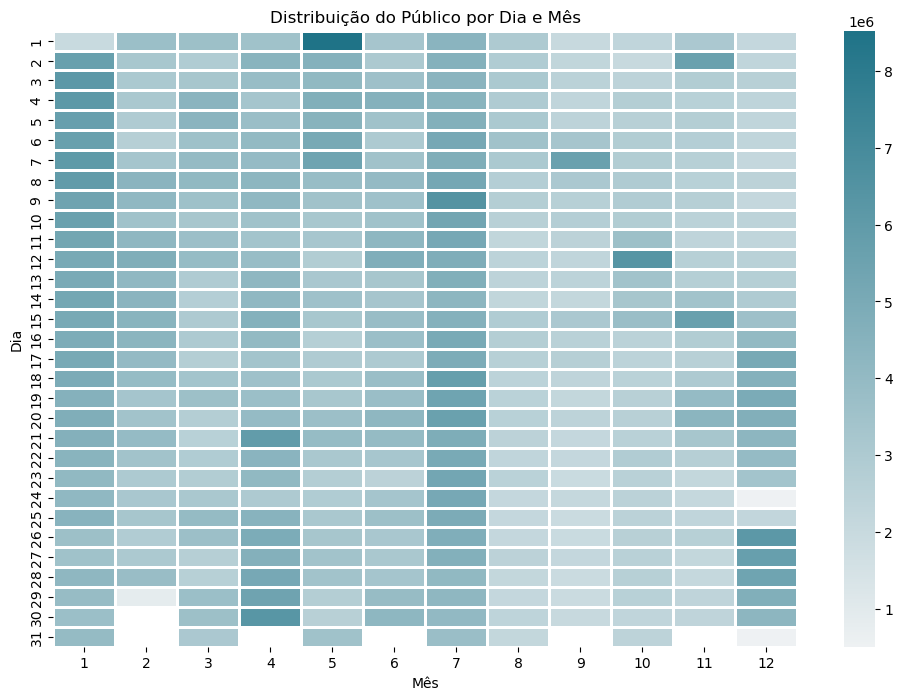

In [100]:
# Converter 'DT_EXIBICAO' para datetime e extrair dia e mês
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['Dia'] = df['DT_EXIBICAO'].dt.day
df['Mes'] = df['DT_EXIBICAO'].dt.month

# Agrupar por dia e mês, somando o público
agrupamento = df.groupby(['Dia', 'Mes'])['PUBLICO'].sum().reset_index()

# Criar DataFrame pivot
pivot_df = agrupamento.pivot(index='Dia', columns='Mes', values='PUBLICO')

# Plotar o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=False, cmap=gradiente1, linewidths=1)
plt.title('Distribuição do Público por Dia e Mês')
plt.xlabel('Mês')
plt.ylabel('Dia')

plt.show()

## Dia da semana com maior público

Você chutou que seria o sábado? Acertou.

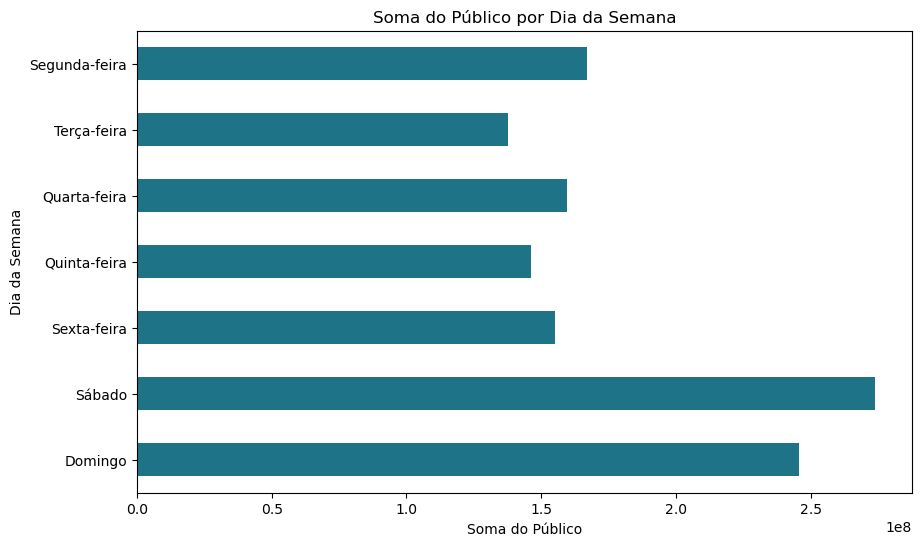

In [101]:
# Converter 'DT_EXIBICAO' para datetime e extrair o dia da semana
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['Dia_da_Semana'] = df['DT_EXIBICAO'].dt.dayofweek

# Mapear os números para os nomes dos dias da semana
dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 
        4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
df['Dia_da_Semana'] = df['Dia_da_Semana'].map(dias)

# Agrupar por dia da semana e calcular a soma do público
soma_publico = df.groupby('Dia_da_Semana')['PUBLICO'].sum()

# Ordem dos dias da semana para o gráfico
ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
soma_publico = soma_publico.reindex(ordem_dias)

# Plotar um gráfico de barras horizontais na ordem correta
plt.figure(figsize=(10, 6))
soma_publico.plot(kind='barh', color=paleta['cor1']) 
plt.title('Soma do Público por Dia da Semana')
plt.xlabel('Soma do Público')
plt.ylabel('Dia da Semana')
plt.gca().invert_yaxis()  
plt.show()


## Mapa de calor por Estado e Mês de exibição do filme.

Uma vez assistindo uma entrevista sobre o mundo dos filmes, alguém mencionou que a indústria não gostava de lançar filmes no final do ano. Bom, nosso gráfico mostra que as bilheterias caem consideravalmente nos últimos meses do ano. Não lembro onde ouvi essa afirmação, mas faz sentido a preocupação. 

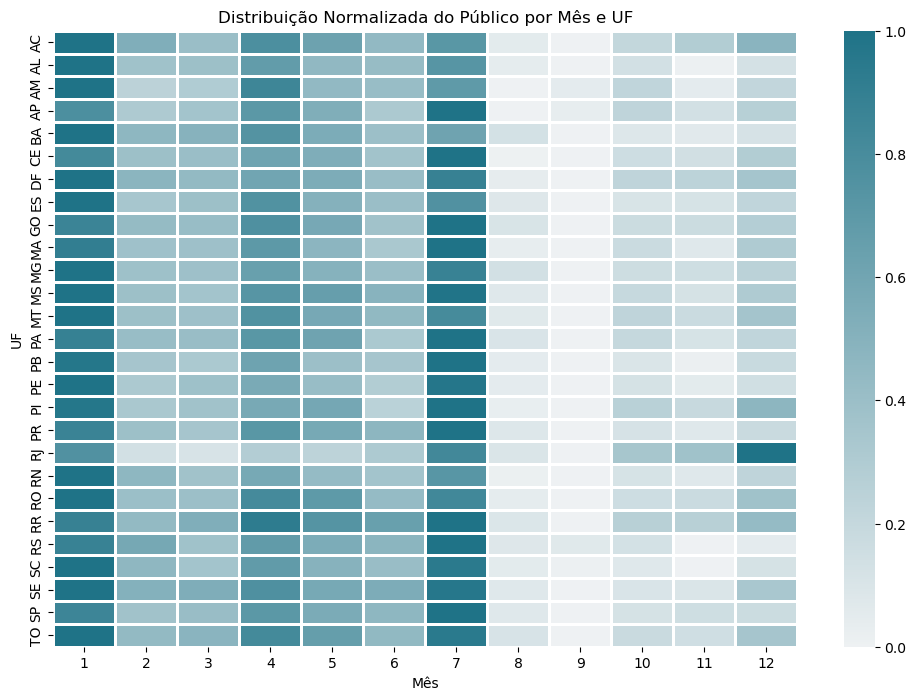

In [102]:
# Converter 'DT_EXIBICAO' para datetime e extrair o mês
df['DT_EXIBICAO'] = pd.to_datetime(df['DT_EXIBICAO'])
df['Mes'] = df['DT_EXIBICAO'].dt.month

# Agrupar por mês e UF, somando o público
agrupamento = df.groupby(['UF_COMPLEXO', 'Mes'])['PUBLICO'].sum().reset_index()

# Criar DataFrame pivot
pivot_df = agrupamento.pivot(index='UF_COMPLEXO', columns='Mes', values='PUBLICO')

# Normalizar os dados dentro de cada UF
pivot_df_norm = pivot_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Plotar o mapa de calor
plt.figure(figsize=(12, 8))
ax = sns.heatmap(pivot_df_norm, annot=False, cmap=gradiente1, linewidths=1)

plt.title('Distribuição Normalizada do Público por Mês e UF')
plt.xlabel('Mês')
plt.ylabel('UF')
plt.show()


## O projeto está em construção

Ainda trarei mais análises sobre esse universo que eu tanto gosto. Tenho um outro projeto que estou desenvolvendo também usando a base da ANCINE, porém consumindo uma quantidade maior dos datasets que estão disponíveis, e tenho realizado cruzamento das informações, gerando arquivos de banco de dados com conceitos de camada raw, silver e gold para no fim, modelar os dados num star schema e criar um dashboard em Power BI. 


Assim que finalizá-lo farei uma publicação sobre e colocarei o link aqui!

Obrigado pra quem me acompanhou até aqui! Se quiser falar comigo, meu chame no [LinkedIn](https://www.linkedin.com/in/bentofh/)